Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""

# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
dtype = torch.FloatTensor

imsize = -1
PLOT = True
sigma = 25
sigma_ = sigma / 255.0

mps_device = torch.device("mps")

In [3]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

# ## denoising
# fname = 'data/denoising/F16_GT.png'

# Load image

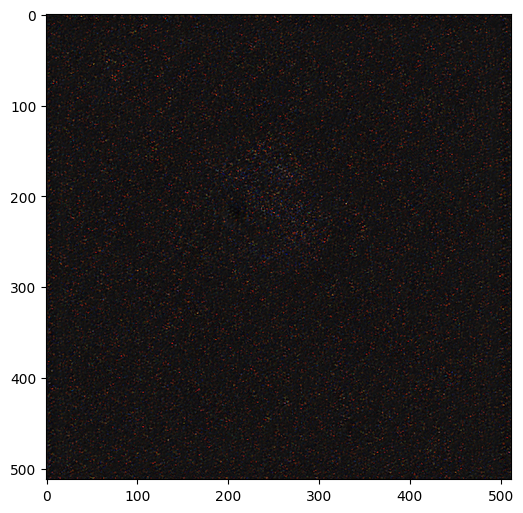

array([[[0.02122184, 0.026829  , 0.06084856, ..., 0.11256279,
         0.14526097, 0.23413387],
        [0.11407382, 0.11407382, 0.0633777 , ..., 0.10376745,
         0.11256279, 0.14526097],
        [0.11407382, 0.11407382, 0.21516705, ..., 0.05991726,
         0.02624092, 0.04971289],
        ...,
        [0.36069861, 0.05739362, 0.05739362, ..., 0.07504685,
         0.06220738, 0.09389986],
        [0.36069861, 0.06287223, 0.104698  , ..., 0.06449402,
         0.06449402, 0.09389986],
        [0.14564492, 0.06287223, 0.05809864, ..., 0.06449402,
         0.06449402, 0.07804675]],

       [[0.07005887, 0.07005887, 0.19976876, ..., 0.08652781,
         0.14526097, 0.19223627],
        [0.07005887, 0.07005887, 0.14259486, ..., 0.08652781,
         0.10376745, 0.14526097],
        [0.07725136, 0.06575225, 0.0633777 , ..., 0.05991726,
         0.02624092, 0.04971289],
        ...,
        [0.08737284, 0.06614237, 0.05330752, ..., 0.07504685,
         0.06873031, 0.09389986],
        [0.0

In [44]:
# # fname = "../Fluo enhancement/TileScan 1_Crop002_t00_RAW_ch01.tif"
# fname = "../Fluo enhancement/apop images21.tiff"

# img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
# img_noisy_np = pil_to_np(img_noisy_pil)
# img_noisy_np -= img_noisy_np.min()
# img_noisy_np /= img_noisy_np.max()

# #     # As we don't have ground truth
# img_pil = img_noisy_pil
# img_np = img_noisy_np

# plot_image_grid([img_np], 4, 5)

# # fname = "../Fluo enhancement/TileScan 1_Crop002_t00_RAW_ch01.tif"
# fname = "../Fluo enhancement/apop images21.tiff"

# img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
# img_noisy_np = pil_to_np(img_noisy_pil)
# img_noisy_np -= img_noisy_np.min()
# img_noisy_np /= img_noisy_np.max()

# #     # As we don't have ground truth
# img_pil = img_noisy_pil
# img_np = img_noisy_np

# plot_image_grid([img_np], 4, 5)

img_all_np = np.load("../Fluo enhancement/apoptosis.npy").transpose(2, 0, 1)


# img_all_np -= img_all_np.min()
# img_all_np /= img_all_np.max()


img_noisy_np = img_all_np[0:3, :, :]
img_noisy_np -= img_noisy_np.min()
img_noisy_np /= img_noisy_np.max()

img_np = img_noisy_np

plot_image_grid([img_np], 4, 5)

# Setup

In [41]:
INPUT = "noise"  # 'meshgrid'
pad = "reflection"
OPT_OVER = "net"  # 'net,input'

reg_noise_std = 1.0 / 30.0  # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER = "adam"  # 'LBFGS'
show_every = 100
exp_weight = 0.99
t = 1

if t == 1:
    num_iter = 500  # 2400
    input_depth = 3
    figsize = 5

    net = skip(
        input_depth,
        3,
        num_channels_down=[8, 16, 32, 64, 128],
        num_channels_up=[8, 16, 32, 64, 128],
        num_channels_skip=[0, 0, 0, 4, 4],
        upsample_mode="bilinear",
        need_sigmoid=True,
        need_bias=True,
        pad=pad,
        act_fun="LeakyReLU",
    )

    net = net.type(dtype)

elif t == 2:
    num_iter = 3000
    input_depth = 32
    figsize = 4

    net = get_net(
        input_depth,
        "skip",
        pad,
        skip_n33d=128,
        skip_n33u=128,
        skip_n11=4,
        n_channels=1,
        num_scales=5,
        upsample_mode="bilinear",
    ).type(dtype)

else:
    assert False

net_input = (
    get_noise(input_depth, INPUT, (img_np.shape[2], img_np.shape[1]))
    .type(dtype)
    .detach()
)

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print("Number of params: %d" % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 572827


# Optimize

Starting optimization with ADAM


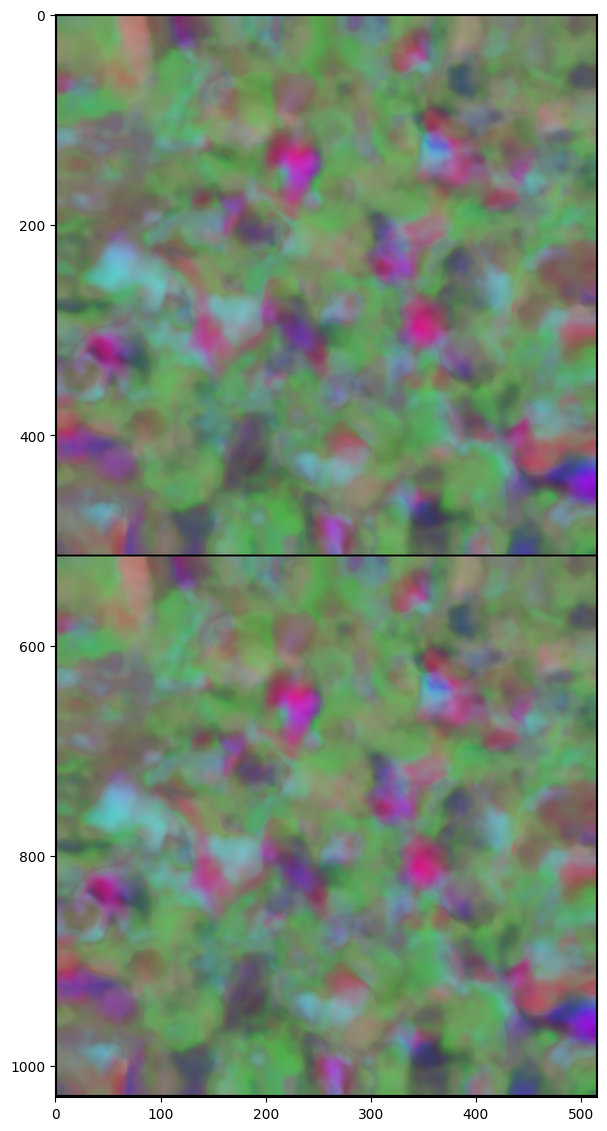

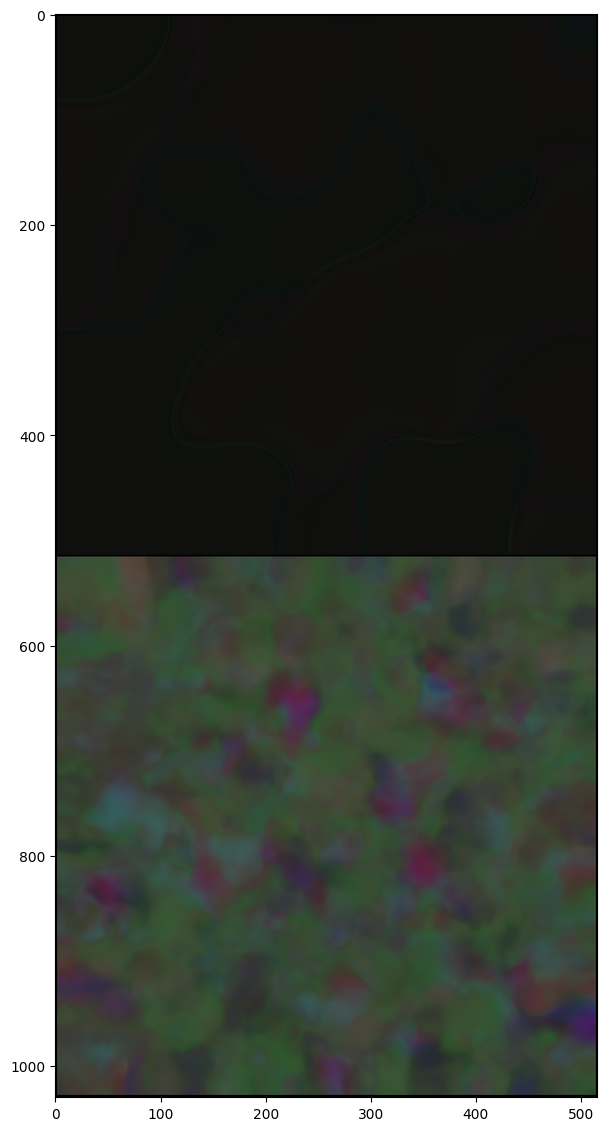

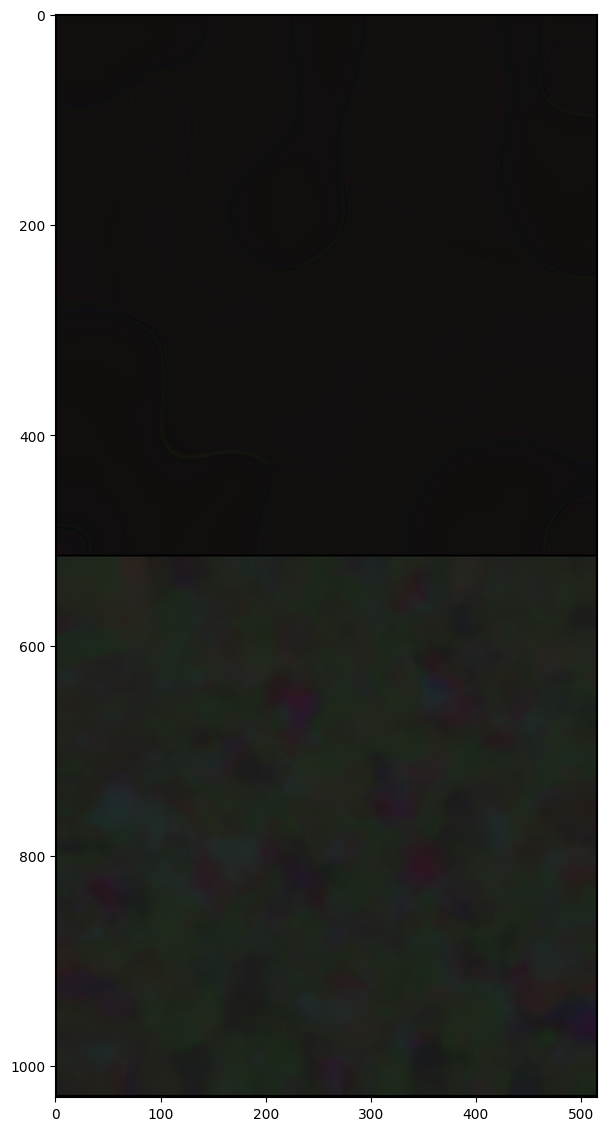

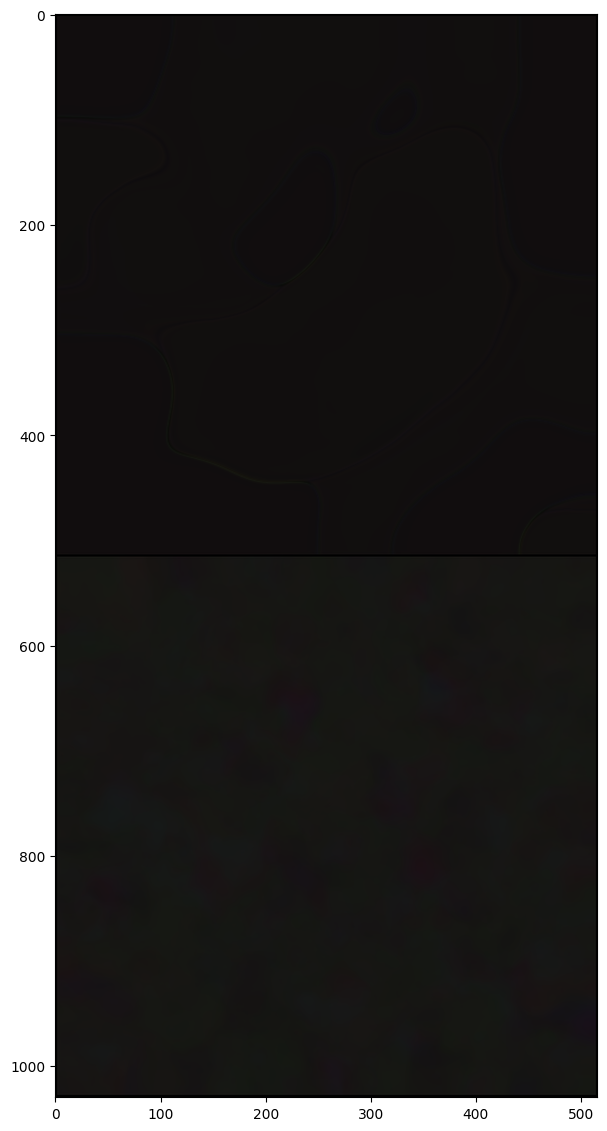

KeyboardInterrupt: 

In [42]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0


def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    # psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    # psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])
    # psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])

    psrn_noisy = peak_signal_noise_ratio(
        img_noisy_np, out.detach().cpu().numpy()[0], data_range=1
    )
    psrn_gt = peak_signal_noise_ratio(
        img_np, out.detach().cpu().numpy()[0], data_range=1
    )
    psrn_gt_sm = peak_signal_noise_ratio(
        img_np, out_avg.detach().cpu().numpy()[0], data_range=1
    )

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print(
        "Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f"
        % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),
        "\r",
        end="",
    )
    if PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid(
            [np.clip(out_np, 0, 1), np.clip(torch_to_np(out_avg), 0, 1)],
            factor=figsize,
            nrow=1,
        )

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print("Falling back to previous checkpoint.")

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss * 0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss


p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

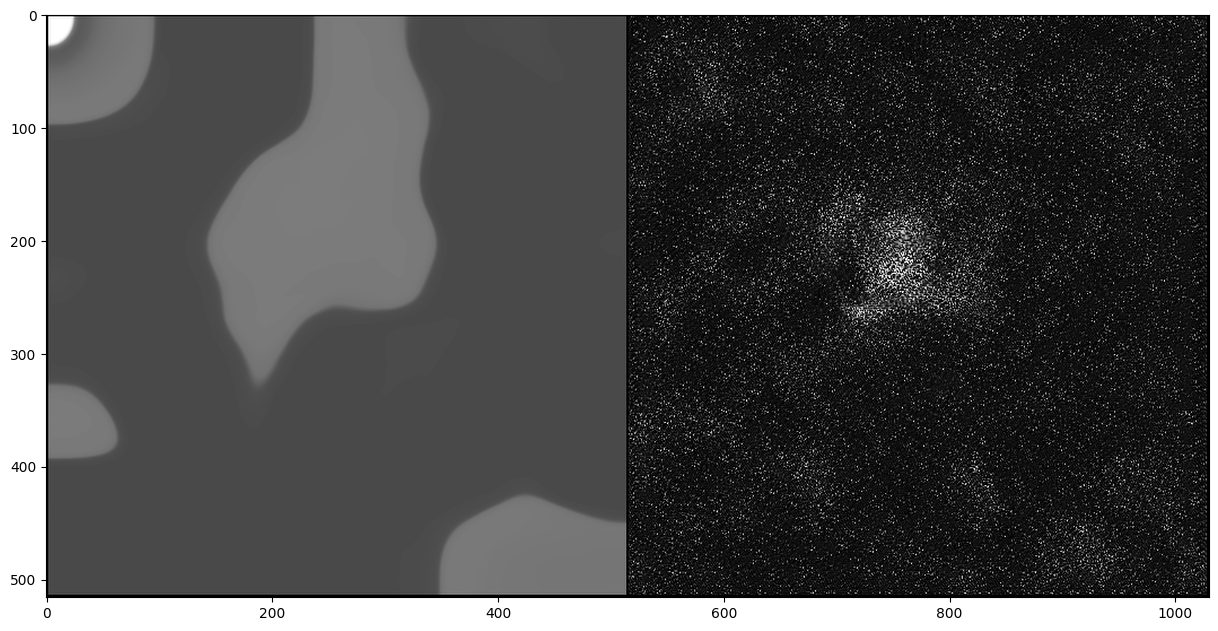

In [37]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13)

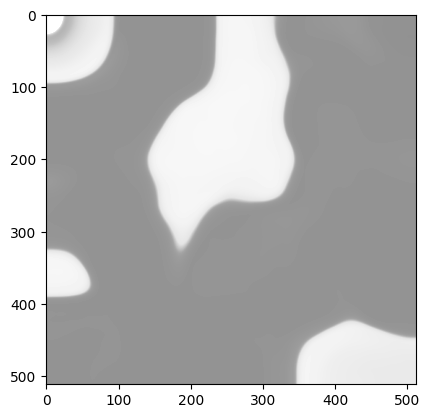

In [38]:
plt.imshow(out_np[0, :, :], vmin=0, vmax=0.5, cmap="gray")

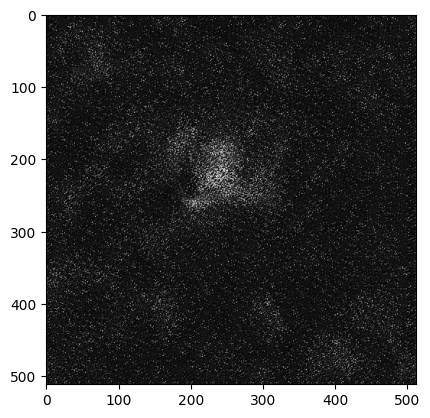

In [14]:
plt.imshow(img_np[0, :, :], vmin=0, vmax=1, cmap="gray")